In [1]:
# Get File from
import os 
import numpy as np 
import pandas as pd

filepath = "./output/sim_000000"

In [6]:
import numpy as np
filepath1 = "/n/home13/henrybae/LearnedCorrections/LearnedCorrections/output/sim_000000"
filepath2 = "/n/home13/henrybae/LearnedCorrections/LearnedCorrections/output/sim_000001"
data1 = np.load(filepath1 + "/velocity_000199.npz", allow_pickle=True)
data2 = np.load(filepath2 + "/velocity_000199.npz", allow_pickle=True)

# Compare each data and print the difference

print("Comparing data1 and data2")
data1_data = data1['data']
data2_data = data2['data']

data_diff = np.abs(data1_data - data2_data)
print("Max Difference: ", np.max())



Comparing data1 and data2
Max Difference:  1.8961728e-05


In [3]:
import tensorflow as tf

2024-07-04 08:05:08.337289: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 08:05:08.384179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 08:05:08.402667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 08:05:08.402692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 08:05:08.414721: I tensorflow/core/platform/cpu_feature_gua

In [18]:
import numpy as np
import os

class DataLoader:
    def __init__(self, simulation_path, batch_size, k):
        self.simulation_path = simulation_path
        self.batch_size = batch_size
        self.k = k
        self.num_simulations, self.num_timesteps = self._count_simulations_and_timesteps()
        self.data = self._load_velocity_data()
        self.batches, self.batch_velocity_std = self._construct_batches()
        self.current_batch_index = 0
        self.current_epoch = 0

    def _count_simulations_and_timesteps(self):
        # Count the number of simulation directories
        simulation_dirs = [d for d in os.listdir(self.simulation_path) if os.path.isdir(os.path.join(self.simulation_path, d))]
        num_simulations = len(simulation_dirs)

        # Count the number of velocity files in the first simulation directory
        first_sim_dir = os.path.join(self.simulation_path, simulation_dirs[0])
        velocity_files = [f for f in os.listdir(first_sim_dir) if f.startswith('velocity') and f.endswith('.npz')]
        num_timesteps = len(velocity_files)

        return num_simulations, num_timesteps

    def _load_velocity_data(self):
        data = []
        for sim in range(self.num_simulations):
            sim_data = []
            sim_dir = os.path.join(self.simulation_path, f'sim_{sim:06d}')
            for timestep in range(self.num_timesteps):
                file_path = os.path.join(sim_dir, f'velocity_{timestep:06d}.npz')
                with np.load(file_path) as npz_file:
                    sim_data.append(npz_file['data'])
            data.append(sim_data)
        return data

    def _get_velocity_std(self, sim_num): 
        # Calculate the standard deviation of the velocity
        velocity_std = np.std(self.data[sim_num])
        return velocity_std 

    def _construct_batches(self):
        input_data = []
        output_data = []
        sim_indices = []
        time_indices = []
        batch_velocity_std = []

        for sim_index, sim_data in enumerate(self.data):
            for i in range(len(sim_data) - self.k):
                input_data.append(sim_data[i])
                output_data.append(sim_data[i + 1: i + self.k + 1])
                sim_indices.append(sim_index)
                time_indices.append(i)

        # Create indices for shuffling
        indices = np.arange(len(input_data))
        np.random.shuffle(indices)

        # Shuffle data
        input_data = np.array(input_data)[indices]
        output_data = np.array(output_data)[indices]
        sim_indices = np.array(sim_indices)[indices]
        time_indices = np.array(time_indices)[indices]

        # Create batches
        num_batches = len(input_data) // self.batch_size
        batches = []
        for i in range(num_batches):
            batch_input = input_data[i * self.batch_size: (i + 1) * self.batch_size]
            batch_output = output_data[i * self.batch_size: (i + 1) * self.batch_size]
            batch_sim_indices = sim_indices[i * self.batch_size: (i + 1) * self.batch_size]
            batch_time_indices = time_indices[i * self.batch_size: (i + 1) * self.batch_size]
            batches.append((batch_input, batch_output, batch_sim_indices, batch_time_indices))

            # Calculate and store standard deviation of the velocity of the batch
            velocity_std = np.std(batch_input)
            batch_velocity_std.append(velocity_std)

        return batches, batch_velocity_std

    def get_batches(self):
        return self.batches, self.batch_velocity_std

    def next_batch(self):
        if self.current_batch_index >= len(self.batches):
            self.current_batch_index = 0
            self.current_epoch += 1

        batch = self.batches[self.current_batch_index]
        batch_std = self.batch_velocity_std[self.current_batch_index]
        self.current_batch_index += 1
        return batch, self.current_batch_index - 1, self.current_epoch, batch_std


# Test Usage
simulation_path = './output'  # path to the directory containing the simulations
batch_size = 20  # desired batch size
k = 4  # future timesteps interval, e.g., 3 timesteps ahead

data_loader = DataLoader(simulation_path, batch_size, k)

# Iterating through batches and printing batch/epoch info with statistics
for _ in range(5):  # Assume we want to see the first 5 batches
    batch, batch_num, epoch_num, batch_std = data_loader.next_batch()
    input_batch, output_batch, sim_indices, time_indices = batch

    input_mean = np.mean(input_batch)
    input_std = np.std(input_batch)
    output_mean = np.mean(output_batch)
    output_std = np.std(output_batch)

    print(f'Batch number: {batch_num}, Epoch number: {epoch_num}')
    print(f'Input batch shape: {input_batch.shape}')
    print(f'Output batch shape: {output_batch.shape}')
    print(f'Simulation indices: {sim_indices}')
    print(f'Time indices: {time_indices}')
    print(f'Input batch mean: {input_mean:.4f}, std: {input_std:.4f}')
    print(f'Output batch mean: {output_mean:.4f}, std: {output_std:.4f}')
    print(f'Batch velocity std: {batch_std:.4f}\n')


Batch number: 0, Epoch number: 0
Input batch shape: (20, 128)
Output batch shape: (20, 4, 128)
Simulation indices: [7 9 7 9 4 1 7 6 6 5 1 8 7 5 3 4 9 3 7 0]
Time indices: [ 31 117 139 101  94 155 191 177 181  92  82  80 119  40 183 182  24  35
   6 178]
Input batch mean: 0.0000, std: 0.0313
Output batch mean: 0.0000, std: 0.0318
Batch velocity std: 0.0313

Batch number: 1, Epoch number: 0
Input batch shape: (20, 128)
Output batch shape: (20, 4, 128)
Simulation indices: [5 0 9 2 0 4 5 0 4 1 5 8 2 7 8 7 5 6 6 5]
Time indices: [ 38  34 104 175  24 143  58  63 119 142 127 103 119  82  53 170  70   9
  29  17]
Input batch mean: 0.0000, std: 0.0259
Output batch mean: 0.0000, std: 0.0264
Batch velocity std: 0.0259

Batch number: 2, Epoch number: 0
Input batch shape: (20, 128)
Output batch shape: (20, 4, 128)
Simulation indices: [2 6 2 1 9 1 6 1 5 1 9 4 3 9 9 0 3 3 9 7]
Time indices: [  3  72 129 176  42 105 128  92 142 128  66   1 161 137 113 142 125  45
 192 101]
Input batch mean: 0.0000, st

In [19]:
simulation_path = './output'  # path to the directory containing the simulations
k = 5  # future timestep interval

In [20]:
import numpy as np
from scipy.signal import convolve

# Input data and velocity function
a = np.array([1, 2, 3, 4, 5])
v = np.array([0.2, 0.5, 0.3])

# Perform the convolution
result = convolve(a, v, mode='same')

print(result)


[0.9 1.9 2.9 3.9 3.7]


In [31]:
import tensorflow as tf

In [32]:
LR = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=LR) 

In [ ]:
#OLD 
import burgers_1d
from phi.flow import *

simulator = burgers_1d.Burgers_1d()

def to_phiflow_format(data):
    # TODO: take in resolution
    return CenteredGrid(math.tensor(data, spatial('x')), extrapolation.PERIODIC, x=int(128), bounds=Box['x', slice(0,2*np.pi)])

def to_numpy_format(data):
    return data.values.numpy('x')


def transformation(velocity_function, output_data):
    # The output data are taken to inner product with the velocity function, but only radially around each point. So if the output is 
    # [a_0, a_1, a_2, a_3, a_4], then the output will be, from the input:
    # [a_2 * v_0 + a_3 * v_1 + a_4 * v_2, a_1 * v_0 + a_2 * v_1 + a_3 * v_2 + a_4 * v_3, a_0 * v_0 + a_1 * v_1 + a_2 * v_2 + a_3 * v_3 + a_4 * v_4, a_0 * v_1 + a_1 * v_2 + a_2 * v_3 + a_3 * v_4 + a_4 * v_5, ...]
    # Make output data just a 1D array
    output_data = tf.reshape(output_data, [-1])
    return convolve(velocity_function, output_data, mode='same')




def training_step(input, output, simulationnumber, init_time, velocity_std, model, optimizer):
    '''
    Input Shape: (dim_x)
    Output Shape: (k, dim_x)
    '''
    simulator.reset()
    # simulation_path/sim_{simulationnumber:06d}/params.json
    print(simulationnumber)
    simulator.change_forcing_dir(os.path.join(simulation_path, f'sim_{simulationnumber:06d}', 'params.json'))
    

    prediction, coefficients = [input], [0]

    with tf.GradientTape() as tape:
        # PhiFlow Simulations will happen here:
        for i in range(k):
            # Can throw an error - see if this needs to be encompased in an array
            prediction_flow = simulator.step(to_phiflow_format(prediction[-1]), t = init_time + i)
            prediction += [to_numpy_format(prediction_flow)]
            

            # model_input = prediction[-1]
            model_input = tf.expand_dims(tf.expand_dims(prediction[-1], 0), -1)  # Reshape to (1, 128, 1)

            model_output = model(model_input)
            coefficients += model_output


            correction = transformation(output[i], coefficients)

            # prediction[-1] = prediction[-1] + correction
            prediction[-1] = prediction[-1] + model_output.numpy().reshape(-1)

        # Calculate the Loss Function - 



        # Calculate the Loss Function
        loss = tf.reduce_mean(tf.square(prediction[1:] - model_output))
        print(loss)

        # Calculate the Gradients
        gradients = tape.gradient(loss, model.trainable_variables)  # Add this line to see the computed gradients
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss
    


CenteredGrid[(xˢ=128), size=(x=6.283), extrapolation=periodic]


In [37]:
import burgers_1d
from phi.flow import *
import tensorflow as tf

simulator = burgers_1d.Burgers_1d()

def to_phiflow_format(data):
    return CenteredGrid(math.tensor(data, spatial('x')), extrapolation.PERIODIC, x=int(128), bounds=Box['x', slice(0, 2 * np.pi)])

def to_numpy_format(data):
    return data.values.numpy('x')

# def transformation(velocity_function, output_data):
#     output_data = tf.reshape(output_data, [-1])
#     return convolve(velocity_function, output_data, mode='same')

@tf.function
def transformation(velocity_function, output_data):
    # Reshape velocity_function to (1, length, 1) and output_data to (filter_length, 1, 1)
    velocity_function = tf.reshape(velocity_function, [1, -1, 1])  # (1, 128, 1)
    output_data = tf.reshape(output_data, [-1, 1, 1])  # (16, 1, 1)

    # Perform the 1D convolution
    convolved_data = tf.nn.conv1d(velocity_function, output_data, stride=1, padding='SAME')

    # Squeeze the output to remove unnecessary dimensions, resulting in (128,)
    return tf.squeeze(convolved_data, axis=[0, 2])

@tf.function
def training_step(input, output, simulationnumber, init_time, velocity_std, model, optimizer):
    '''
    Input Shape: (dim_x)
    Output Shape: (k, dim_x)
    '''
    simulator.reset()


    

    simulator.change_forcing_dir(os.path.join(simulation_path, f'sim_{simulationnumber:06d}', 'params.json'))
    

    prediction, coefficients = [input], [0]

    with tf.GradientTape() as tape:
        for i in range(k):
            prediction_flow = simulator.step(to_phiflow_format(prediction[-1]), t=init_time + i)
            prediction_flow = to_numpy_format(prediction_flow)

            prediction_flow_normalized = np.divide(prediction_flow, (velocity_std + 1e-6))
    
            prediction += [prediction_flow]

            model_input = tf.expand_dims(tf.expand_dims(prediction_flow_normalized, 0), -1)  # Reshape to (1, 128, 1)
            # Get shape of model_input

            model_output = model(model_input)
            coefficients += model_output

            correction = transformation(prediction[-1], model_output)
            #prediction[-1] = prediction[-1] + tf.reshape(model_output, [-1])
            prediction[-1] = prediction[-1] + correction

        # Calculate the Loss Function
        final_prediction = tf.stack(prediction[1:]) 
    
        loss = tf.reduce_sum(tf.square(final_prediction - output))
        # Calculate the Gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss


CenteredGrid[(xˢ=128), size=(x=6.283), extrapolation=periodic]


In [38]:
# #TESTING
# def training_step(input, output, simulationnumber, init_time, velocity_std, model, optimizer):
#     '''
#     Input Shape: (dim_x)
#     Output Shape: (k, dim_x)
#     '''
#     simulator.reset()

#     simulator.change_forcing_dir(os.path.join(simulation_path, f'sim_{simulationnumber:06d}', 'params.json'))
    
#     # Normalize input and output by the standard deviation
#     normalized_input = input / velocity_std
#     normalized_output = output / velocity_std

#     prediction, coefficients = [normalized_input], [0]

#     with tf.GradientTape() as tape:
#         for i in range(k):
#             prediction_flow = simulator.step(to_phiflow_format(prediction[-1]), t=init_time + i)
#             prediction += [to_numpy_format(prediction_flow)]

#             model_input = tf.expand_dims(tf.expand_dims(prediction[-1], 0), -1)  # Reshape to (1, 128, 1)
#             model_output = model(model_input)
#             coefficients += model_output

#             correction = transformation(normalized_output[i], coefficients)
#             prediction[-1] = prediction[-1] + tf.reshape(model_output, [-1])

#         # Calculate the loss for each step
#         loss_steps = [
#             tf.nn.l2_loss(
#                 (normalized_output[i] - prediction[i+1]) * velocity_std
#             )
#             for i in range(k)
#         ]
        
#         # Sum the losses and average them
#         total_loss = tf.reduce_sum(loss_steps) 

#         # Calculate the gradients
#         gradients = tape.gradient(total_loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#         return total_loss


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models


2024-07-06 15:08:15.278816: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 15:08:19.154436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 15:08:20.473236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 15:08:20.483289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-06 15:08:23.185668: I tensorflow/core/platform/cpu_feature_gua

In [25]:
batch_size = 32  # desired batch size

data_loader = DataLoader(simulation_path, batch_size, k)

num_coef = 8


# Convolutional Neural Network Model - 1-D
model = tf.keras.Sequential([
    # Input layer
    layers.InputLayer(input_shape=(128, 1)),
    
    # Convolutional layer 1
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    
    # Convolutional layer 2
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    
    # Convolutional layer 3
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    
    # Convolutional layer 4
    layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    
    # Flattening the output for the Dense layer
    layers.Flatten(),
    
    # Dense layer 1
    layers.Dense(256, activation='relu'),
    
    # Dense layer 2
    layers.Dense(256, activation='relu'),
    
    # Dense layer 3
    layers.Dense(64, activation='relu'),
    
    # Output layer
    layers.Dense(16)
])

# Compile the model (example for a regression problem)
model.compile(optimizer='adam')  # Use 'categorical_crossentropy' for classification

# Summary of the model
model.summary()





/n/home13/henrybae/.conda/envs/tf2.16.1_cuda12.1/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737,424 (2.81 MB)

 Trainable params: 737,424 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
train_loss = tf.keras.metrics.Mean(name='train_loss')


In [34]:
train_step_jit = math.jit_compile(training_step)

In [39]:
Epochs = 1

for epoch in range(Epochs):
    print(f"Epoch {epoch + 1}/{Epochs}")
    batches, batch_velocity_stds = data_loader.get_batches()  # Correctly receive both returned lists
    for batch, velocity_std in zip(batches, batch_velocity_stds):  # Use zip to iterate over both lists simultaneously
        input_batch, output_batch, sim_indices, time_indices = batch  # Correctly unpack the batch
        
        batch_losses = []  # Store losses for the current batch
        
        for i in range(len(input_batch)):
            # Assuming train_step_jit and train_loss are defined elsewhere and work as intended
            loss = training_step(input_batch[i], output_batch[i], sim_indices[i], time_indices[i], velocity_std, model, optimizer)
            batch_losses.append(loss)
        
        # Print the average loss for the current batch
        avg_batch_loss = tf.reduce_mean(batch_losses)
        print(f"Batch average loss: {avg_batch_loss:.8f}")
    
    print("End of epoch\n")

Epoch 1/1


TypeError: in user code:

    File "/tmp/ipykernel_2696699/2061396843.py", line 40, in training_step  *
        simulator.change_forcing_dir(os.path.join(simulation_path, f'sim_{simulationnumber:06d}', 'params.json'))

    TypeError: unsupported format string passed to SymbolicTensor.__format__


In [213]:
model.save('./nn_final.h5')
model.save('./nn_final.keras')

/Users/henrybae/miniconda3/envs/90R/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [214]:
# Load the Model:
from tensorflow.keras import models

model = models.load_model('./nn_final.h5')

200


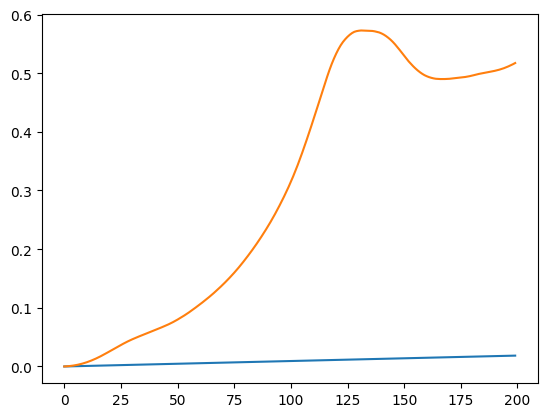

In [221]:


def simulate_all(): 
    # Take the first one for now as testing
    data = data_loader.data[0]
    velocity_std = data_loader. _get_velocity_std(0)

    # TODO: Change - for testing 
    param_path = os.path.join(simulation_path, 'sim_000000', 'params.json')
    simulator.change_forcing_dir(param_path)
    
    simulation_nocorrection = []
    simulation_correction = []

    simulation_nocorrection.append(data[0])
    simulation_correction.append(data[0])

    # Note that dt = 0.001
    for i in range(len(data)-1):
        # Run the PhiFlow Simulation:
        simulation_nocorrection.append(to_numpy_format(simulator.step(to_phiflow_format(simulation_nocorrection[-1]), t = i * 0.001)))
    
    # Run the PhiFlow Simulation with Correction:
    for i in range(len(data)-1):
       
        prediction_flow = simulator.step(to_phiflow_format(simulation_correction[-1]), t=i * 0.001)
        prediction_flow = to_numpy_format(prediction_flow)

        prediction_flow_normalized = np.divide(prediction_flow, (velocity_std + 1e-6))

        simulation_correction += [prediction_flow]

        model_input = tf.expand_dims(tf.expand_dims(prediction_flow_normalized, 0), -1)  # Reshape to (1, 128, 1)
        # Get shape of model_input

        model_output = model(model_input)
        

        correction = transformation(simulation_correction[-1], model_output)
        #prediction[-1] = prediction[-1] + tf.reshape(model_output, [-1])
        simulation_correction[-1] = simulation_correction[-1] + correction
    return simulation_nocorrection, simulation_correction

# For each time calculate the l2 norm of the difference between the two simulations then plot it 
simulation_nocorrection, simulation_correction = simulate_all()

l2_norms_nocorrection = [np.linalg.norm(data_loader.data[0][i] - simulation_nocorrection[i]) for i in range(len(simulation_nocorrection))]
l2_norms_correction = [np.linalg.norm(data_loader.data[0][i] - simulation_correction[i]) for i in range(len(simulation_correction))]





        
    
    
test_data = data_loader.data[0]
print(len(test_data))    



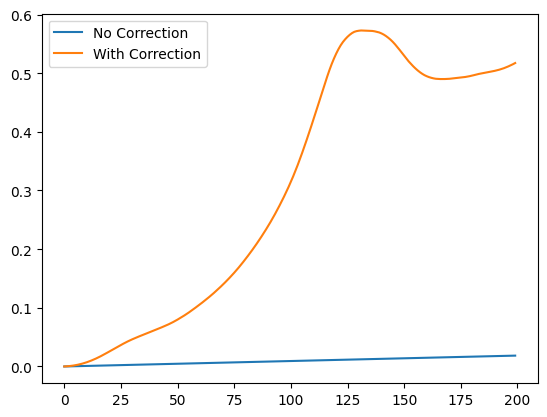

In [223]:
import matplotlib.pyplot as plt

plt.plot(l2_norms_nocorrection, label='No Correction')
plt.plot(l2_norms_correction, label='With Correction')
plt.legend()
